In [6]:
import sys
sys.path.append("..")
from alphabet import load_alphabet
from alphabet import A
import numpy as np
import matplotlib.pyplot as plt
from synthetic import DataGenerator, SynthSettings
from noise import Noise

alphabet = load_alphabet()

In [3]:
elements_per_class = {cls: len(images) for cls, images in alphabet.items()}
classes = list(elements_per_class.keys())
classes.sort()
counts = list(elements_per_class.values())
print(counts)

[300, 300, 193, 300, 10, 300, 300, 300, 116, 294, 300, 300, 300, 300, 37, 78, 23, 300, 265, 91, 12, 300, 15, 300, 73, 300, 130]


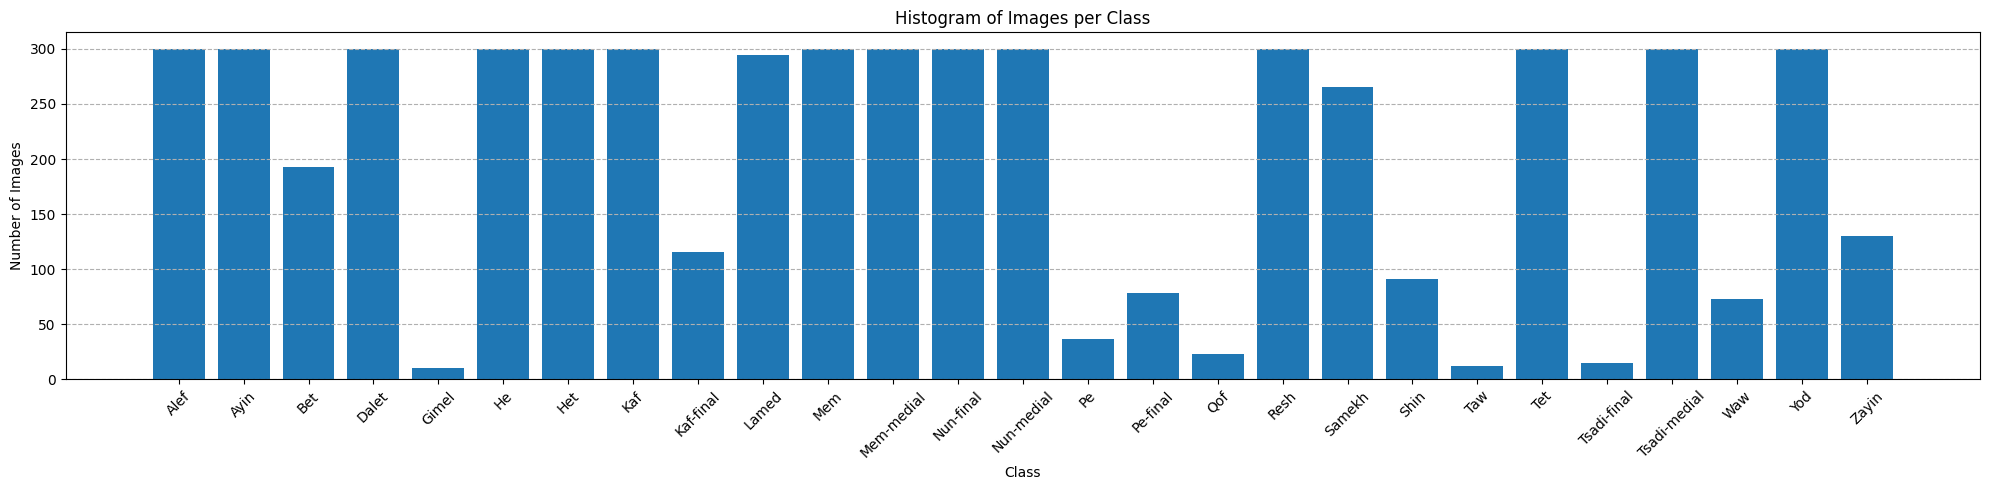

In [46]:
plt.figure(figsize=(20,5))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Histogram of Images per Class')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [7]:

settings = SynthSettings(downscale_factor=0.3)
generator = DataGenerator(settings=settings)
tokens, masks, scrolls = generator.generate_ngram_scrolls(1000)

: 

102


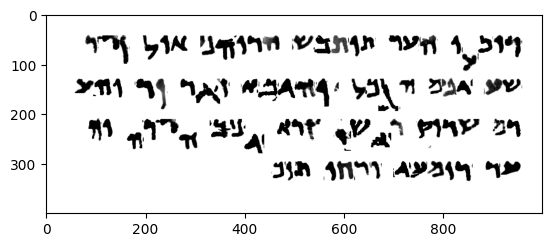

In [30]:
plt.imshow(scrolls[0], cmap="gray")
print((tokens[0] > -1).sum())

In [ ]:
noiser = Noise(image_size=generator.settings.image_size)
noiser.create_masks(5)

(400, 1000) (400, 1000) (400, 1000)


In [24]:
dmgd_scrolls = noiser.damage(images = scrolls, strength=0.2)

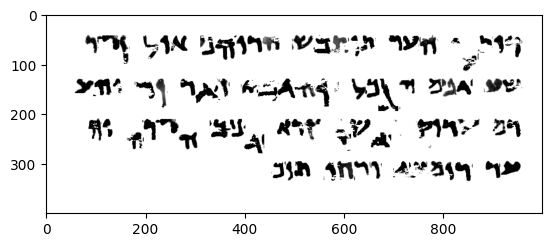

In [25]:
plt.imshow(dmgd_scrolls[0], cmap="gray")